In [2]:
import biom
import json

import os
import numpy as np

import crispr_assembler as ca

import matplotlib.pyplot as plt

import tqdm

from multiprocessing import Pool, pool

In [3]:
table = biom.load_table("../HMP/ibd/genome/microbiome/16s/analysis/hmqcp/CSM5FZ3N.biom/CSM5FZ3N.biom")

In [11]:
%%timeit 
next(table.iter_data())

199 µs ± 2.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit 
table.to_dataframe().values

15.8 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
15 / 199 * 1000

75.37688442211055

In [3]:
table_json = json.load(open("../HMP/ibd/genome/microbiome/16s/analysis/hmqcp/CSM5FZ3N.biom/CSM5FZ3N.biom", 'rb'))

In [20]:
path_ibd = "../HMP/ibd/genome/microbiome/16s/analysis/hmqcp/"

In [21]:
path_ptb = "../HMP/ptb/genome/microbiome/16s/analysis/hmqcp/"

In [22]:
path_t2d = "../HMP/t2d/genome/microbiome/16s/analysis/hmqcp/"

In [17]:
def process_file(t):
    table_json = json.loads(t.to_json("OTU table"))

    gs = []

    for x in table_json['rows']:
        taxonomy = x['metadata']['taxonomy']
        if len(taxonomy) > 1:
            gs.append(taxonomy[-2])
#                gs_set.add(taxonomy[-2])
        else:
            gs.append(taxonomy[0])
#                gs_set.add(taxonomy[0])

    mask = np.array([len(x) > 3 for x in gs])
    try:
        data = np.array(next(t.iter_data()))
        presented = data[mask]
        ratio_to_sum = presented.sum() / data.sum()
        ratio_to_max = presented.sum() / data.max()
        l = len(data)
        fails = 0
    except:
        ratio_to_sum = -1
        ratio_to_max = -1
        l = -1
        fails = 1

    return ratio_to_sum, ratio_to_max, l, fails

In [18]:
def process_tables(ts):
#     p = Pool(8)
#     r = list(tqdm.tqdm(p.imap(process_file, ts), total=len(ts)))
#     return r
    r = [process_file(x) for x in tqdm.tqdm(ts)]
    return r

In [19]:
def load_path(path):
    fnames = os.listdir(path)
    ts = []
    fails = 0
    for f in tqdm.tqdm(fnames):
        try:
            ts.append(biom.load_table(path + f + "/" + f))
        except:
            fails += 1
            
    return ts, fails

In [23]:
ts_ptb, fails_ptb = load_path(path_ptb)
ts_ibd, fails_ibd = load_path(path_ibd)
ts_t2d, fails_t2d = load_path(path_t2d)

100%|██████████| 1044/1044 [00:39<00:00, 26.10it/s]


In [26]:
print(len(ts_ptb),fails_ptb)
print(len(ts_ibd),fails_ibd)
print(len(ts_t2d),fails_t2d)


3457 5
86 0
1044 0


In [27]:
r_ptb = process_tables(ts_ptb)


100%|██████████| 3457/3457 [01:15<00:00, 45.77it/s]


In [28]:
r_ibd = process_tables(ts_ibd)
r_t2d = process_tables(ts_t2d)

100%|██████████| 1044/1044 [01:29<00:00, 11.63it/s]


Text(0.5,1,'ptb')

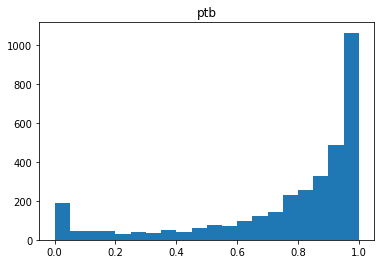

In [33]:
_ = plt.hist([x[0] for x in r_ptb], bins = 20)
plt.title("ptb")

Text(0.5,1,'t2d')

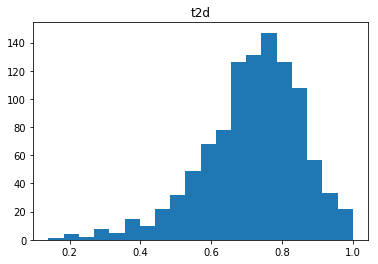

In [92]:
_ = plt.hist([x[0] for x in r_t2d], bins = 20)
plt.title("t2d")

In [35]:
table = biom.load_table("../deblur_125nt_no_blooms_normed.biom")

In [43]:
for i in table.ids()[:5]:
    print(i)
    print(table.data(i), len(table.data(i)))

10317.000012326
[0.         0.         0.16829869 ... 0.         0.         0.        ] 32954
10317.000054127
[0. 0. 0. ... 0. 0. 0.] 32954
10317.000030973
[0. 0. 0. ... 0. 0. 0.] 32954
10317.000069160
[0. 0. 0. ... 0. 0. 0.] 32954
10317.000059092
[0. 0. 0. ... 0. 0. 0.] 32954


In [ ]:
table.get_value_by_ids()

In [49]:
next(table.iter())

(array([0.        , 0.        , 0.16829869, ..., 0.        , 0.        ,
        0.        ]), '10317.000012326', None)

In [50]:
next(table.iter_pairwise())

((array([0.        , 0.        , 0.16829869, ..., 0.        , 0.        ,
         0.        ]), '10317.000012326', None),
 (array([0., 0., 0., ..., 0., 0., 0.]), '10317.000054127', None))

In [81]:
mask = [len(table.metadata(s, axis='observation')['taxonomy'][-2]) > 3 for s in table.ids(axis='observation')[:]]

In [82]:
len(mask)

32954

In [83]:
sum(mask)

16404

In [88]:
ts_old = []
for row in table.iter_data():
    ts_old.append(row[mask].sum() / row.sum())

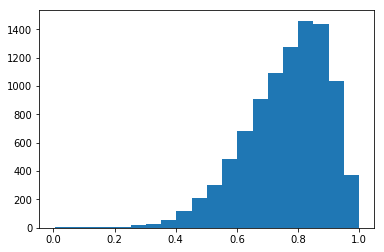

In [91]:
_ = plt.hist([x for x in ts_old], bins = 20)

In [93]:
rows_sum = np.zeros(table.shape[0])
for row in table.iter_data():
    rows_sum += row

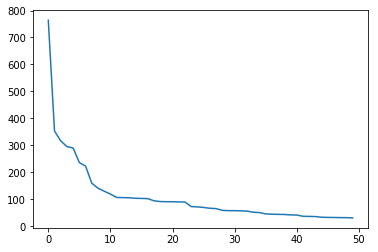

In [100]:
plt.plot((sorted(rows_sum)[::-1][:50]))

In [86]:
next(table.iter_data())

array([0.        , 0.        , 0.16829869, ..., 0.        , 0.        ,
       0.        ])

In [61]:
collapse_f = lambda id_, md: '; '.join(md['taxonomy'])
collapsed = table.head().collapse(collapse_f, axis='observation')

In [65]:
collapsed.__str__()

'# Constructed from biom file\n#OTU ID\t10317.000012326\t10317.000054127\t10317.000030973\t10317.000069160\t10317.000059092\nk__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Roseburia; s__\t0.0\t0.0\t0.0\t0.0\t0.0\nk__Bacteria; p__Cyanobacteria; c__4C0d-2; o__YS2; f__; g__; s__\t0.0\t0.0\t0.0\t0.0\t0.0\nk__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__S24-7; g__; s__\t0.1682986856574331\t0.0\t0.0\t0.0\t0.0\nk__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__Bacteroidaceae; g__Bacteroides; s__\t0.11834319526627218\t0.0\t0.18998222770302128\t0.21675746182766822\t0.01131770412287793\nk__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__Coprococcus; s__eutactus\t0.07603288474629523\t0.0\t0.0\t0.0\t0.0'

In [72]:
table.metadata('AACGTAGGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGAAGGCTAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGGTCATCTAGAGTG',
              axis='observation')

defaultdict(<function biom.table.Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda>()>,
            {'taxonomy': ['k__Bacteria',
              'p__Firmicutes',
              'c__Clostridia',
              'o__Clostridiales',
              'f__Lachnospiraceae',
              'g__Roseburia',
              's__']})

In [71]:
table.ids(axis='observation')

array(['AACGTAGGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGAAGGCTAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGGTCATCTAGAGTG',
       'TACGGAGGGTGCAAGCGTTGTCCGGAATCATTGGGCGTAAAGAGTTCGTAGGTGGTTTGTTAAGTTTGGTGTTAAATGCAGAGGCTCAACTTCTGTTCGGCATCGGATACTGGCAGACTAGAATG',
       'TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGACCATCAAGTCAGCGGTCAAAAGTCGGGGCTCAACCCCGTAAAGCCGTTGAAACTGGCGGTCTGGAGTGA',
       ...,
       'TACGTAGGTGGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCATGCAGGCGGTTTTTTAAGTCTGGAGTGAAAATGCGGGGCTCAACCCCGTATGGCTCTGGATACTGGAAGACTTGAGTGC',
       'TACGGAGGATGCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGACGGCGTGTCAAGTCAGCTGTGAAAGTTCGGGGCTCAACCTTGGAATTGCAGTTGAAACTGGCGCGCTTGAGTT',
       'TACGGGGGATGCGAGCGTTATCCGGATTCATTGGGTTTAAAGGGTGCGCAGGCCGAGGTTCAAGTCAGCGGTGAAACCCCCGCGCTCAACGCGGGGCATGCCGTTGATACTGTATCTCTGGAGTA'],
      dtype=object)

In [69]:
for (i, md) in table.iter():
    print(md['taxonomy'])

ValueError: too many values to unpack (expected 2)

In [70]:
next(table.iter())

(array([0.        , 0.        , 0.16829869, ..., 0.        , 0.        ,
        0.        ]), '10317.000012326', None)

In [45]:
table_json = json.load(open(path + f + "/" + f, 'rb'))

NameError: name 'path' is not defined

In [166]:
table_json['data']

[[0, 0, 1.0]]

In [167]:
table_json['rows']

[{'id': '4433947',
  'metadata': {'taxonomy': ['k__Bacteria',
    'p__Bacteroidetes',
    'c__Bacteroidia',
    'o__Bacteroidales',
    'f__Bacteroidaceae',
    'g__Bacteroides',
    's__']}}]

In [168]:
table_json

{'rows': [{'id': '4433947',
   'metadata': {'taxonomy': ['k__Bacteria',
     'p__Bacteroidetes',
     'c__Bacteroidia',
     'o__Bacteroidales',
     'f__Bacteroidaceae',
     'g__Bacteroides',
     's__']}}],
 'format': 'Biological Observation Matrix 1.0.0',
 'data': [[0, 0, 1.0]],
 'columns': [{'id': 'ESM5MEBA', 'metadata': None}],
 'generated_by': 'AnADAMA',
 'matrix_type': 'sparse',
 'shape': [1, 1],
 'format_url': 'http://biom-format.org',
 'date': '2015-09-18T09:38:46.791724',
 'type': 'OTU table',
 'id': None,
 'matrix_element_type': 'float'}

In [147]:
gs_set

{'g__',
 'g__AF12',
 'g__Acidaminococcus',
 'g__Acidocella',
 'g__Acinetobacter',
 'g__Actinobacillus',
 'g__Actinomyces',
 'g__Adlercreutzia',
 'g__Aggregatibacter',
 'g__Agrobacterium',
 'g__Akkermansia',
 'g__Allobaculum',
 'g__Alloscardovia',
 'g__Anaerofustis',
 'g__Anaerostipes',
 'g__Anaerotruncus',
 'g__Atopobium',
 'g__Bacillus',
 'g__Bacteroides',
 'g__Bifidobacterium',
 'g__Bilophila',
 'g__Blautia',
 'g__Bradyrhizobium',
 'g__Bulleidia',
 'g__Burkholderia',
 'g__Butyricimonas',
 'g__CF231',
 'g__Campylobacter',
 'g__Cardiobacterium',
 'g__Christensenella',
 'g__Chryseobacterium',
 'g__Citrobacter',
 'g__Clostridium',
 'g__Collinsella',
 'g__Conchiformibius',
 'g__Coprobacillus',
 'g__Coprococcus',
 'g__Corynebacterium',
 'g__Cryocola',
 'g__Desulfovibrio',
 'g__Dialister',
 'g__Dietzia',
 'g__Dorea',
 'g__Dysgonomonas',
 'g__Eggerthella',
 'g__Eikenella',
 'g__Enterobacter',
 'g__Enterococcus',
 'g__Epulopiscium',
 'g__Erwinia',
 'g__Faecalibacterium',
 'g__Flexispira',
 'g

In [133]:
for gs in all_gs:
    mask = np.array([len(x) > 3 for x in gs])
    print( sum(mask)/ len(mask), len(mask))

0.534965034965035 572
0.5838150289017341 346
0.68125 160
0.4776725304465494 739
0.523109243697479 476
0.4786516853932584 445
0.48358862144420134 457
0.45539033457249073 538
0.4156769596199525 421
0.47282608695652173 552
0.39763779527559057 1016
0.632258064516129 310
0.47123893805309736 452
0.5889830508474576 236
0.5389048991354467 347
0.42992125984251967 635
0.672566371681416 226
0.4398563734290844 557
0.5483870967741935 496
0.5845272206303725 349
0.4419047619047619 525
0.45789473684210524 760
0.4752475247524752 505
0.4533898305084746 472
0.44793713163064836 509
0.47527910685805425 627
0.5393939393939394 330
0.4648876404494382 712
0.5381165919282511 446
0.42524271844660194 515
0.4797101449275362 690
0.6134663341645885 401
0.38746438746438744 702
0.4872881355932203 472
0.6376811594202898 138
0.43513513513513513 740
0.4772234273318872 461
0.5046728971962616 428
0.4904109589041096 365
0.49019607843137253 357
0.4602076124567474 867
0.49552772808586765 559
0.7122302158273381 278
0.648648648

0.5371024734982333 566
0.4965034965034965 715
0.5471698113207547 212
0.46 650
0.4186991869918699 492
0.5237020316027088 443
0.42234848484848486 528
0.46771037181996084 511
0.43222003929273084 509
0.4442988204456094 763
0.44329896907216493 582
0.4334677419354839 496
0.4204081632653061 490
0.5757575757575758 396
0.4753199268738574 547
0.43640350877192985 456
0.44563758389261743 745
0.4097902097902098 715
0.39325842696629215 979
0.4955595026642984 563
0.42727272727272725 660
0.5090252707581228 277
0.5405405405405406 259
0.4278169014084507 568
0.5888888888888889 450
0.5531914893617021 376
0.5473684210526316 285
0.41442953020134227 596
0.46273637374860954 899
0.5403422982885085 409
0.44724770642201833 436
0.49230769230769234 455
0.44485981308411215 535
0.3943298969072165 388
0.4838709677419355 310
0.44329896907216493 582
0.4978165938864629 458
0.47438752783964366 449
0.4701298701298701 385
0.4318181818181818 792
0.512372634643377 687
0.5727969348659003 522
0.43874643874643876 351
0.46010186

0.5403726708074534 322
0.602112676056338 284
0.4680365296803653 438
0.4122681883024251 701
0.5605263157894737 380
0.40471092077087795 467
0.5452054794520548 365
0.46153846153846156 299
0.4765886287625418 598
0.5231053604436229 541
0.49169435215946844 602
0.5373831775700935 428
0.41865509761388287 922
0.38493723849372385 956
0.5748987854251012 247
0.4740484429065744 289
0.4272863568215892 667
0.46131805157593125 698
0.4799301919720768 573
0.48722986247544203 509
0.5097402597402597 616
0.4420401854714065 647
0.46119402985074626 670
0.45314685314685316 715
0.49521531100478466 418
0.4088586030664395 587
0.6424731182795699 372
0.4717391304347826 460
0.5614035087719298 285
0.4382530120481928 664
0.4513888888888889 576
0.6915584415584416 308
0.5014749262536873 339
0.49217002237136465 447
0.46131805157593125 698
0.4192399049881235 842
0.4028662420382166 628
0.5253731343283582 335
0.47619047619047616 609
0.46441281138790036 562
0.6351791530944625 307
0.41369047619047616 1008
0.4105011933174224 

In [108]:
import chardet

In [109]:
chardet.detect(contents)

{'encoding': 'Windows-1254',
 'confidence': 0.3859881932121052,
 'language': 'Turkish'}

In [93]:
table_json = json.load(open(path + f + "/" + f, 'rb'), )

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [55]:
table = biom.load_table(path + f + "/" + f)

In [60]:
table.head()

5 x 1 <class 'biom.table.Table'> with 5 nonzero entries (100% dense)

In [113]:
f = fnames[0]

In [114]:
table_json = json.load(open(path + f + "/" + f, 'r', encoding='Windows-1254'))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 5296: character maps to <undefined>

In [115]:
f = fnames[0]

In [107]:
with open(path + f + "/" + f, 'r', encoding='cp1252') as f:
    contents = f.read()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 5296: character maps to <undefined>

In [117]:
t = biom.load_table(path + f + "/" + f)

json.loads(t.to_json("OTU table"))['rows']

In [104]:
contents

b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xd0\x0e\x03\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\xa8\x02\x00\x00\x00\x00\x00\x00\x01\x00\x0b\x00\x01\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x10\x00\x10\x00\x00\x00\x00\x00 \x03\x00\x00\x00\x00\x00\x00\x98\x02\x00\x00\x00\x00\x00\x00TREE\x00\x00\x01\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x18\x00\x00\x00\x00\x00\x00\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [95]:
json.loads(contents)
#contents

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [73]:
json.load(open(path + f + "/" + f, 'rb'))

TypeError: must be str, not _io.BufferedReader

In [5]:
table.data()

TypeError: data() missing 1 required positional argument: 'id'

In [5]:
table = biom.load_table("..//deblur_125nt_no_blooms_normed.biom")

In [8]:
table.ids()

array(['10317.000012326', '10317.000054127', '10317.000030973', ...,
       '10317.000038006', '10317.000038352', '10317.000038478'],
      dtype=object)

In [10]:
table.data('10317.000012326')

array([0.        , 0.        , 0.16829869, ..., 0.        , 0.        ,
       0.        ])

In [22]:
table.index()

TypeError: index() missing 2 required positional arguments: 'id' and 'axis'

In [23]:
tsv = table.to_tsv()

In [ ]:
with

In [28]:
json = table.to_json()

TypeError: to_json() missing 1 required positional argument: 'generated_by'

In [27]:
tsv[10000000:100000000]

KeyboardInterrupt: 

In [ ]:
table.he

In [14]:
h = table.head()

In [4]:
table.shape

(32954, 9511)

In [6]:
data = np.zeros(table.shape[::-1])

In [7]:
for i, idx in tqdm_notebook(enumerate(table.ids())):
    data[i] = table.data(idx)

A Jupyter Widget

In [15]:
np.save("../data/2/data", data)

In [32]:
del data

In [1]:
import numpy as np
from tqdm import tqdm_notebook

In [2]:
import matplotlib.pyplot as plt

In [21]:
data = np.load("../data/2/data.npy").astype(np.float16)

In [5]:
data.shape

(9511, 32954)

PCA

In [3]:
cc = np.load("../data/2/PCA_centered_components.npy").astype(np.float16)

In [4]:
cd = np.load("../data/2/PCA_centered_data.npy").astype(np.float16)

In [5]:
ce = np.load("../data/2/PCA_centered_eigvals.npy").astype(np.float16)

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


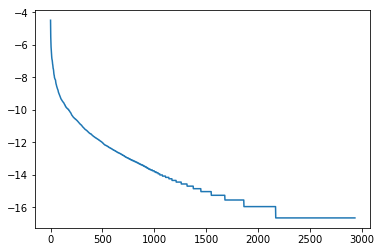

In [6]:
plt.plot(np.log(ce))


In [38]:
cc.shape

(9511, 32954)

In [8]:
cc_main = cc[:2200]

In [26]:
from sklearn.decomposition import PCA

In [10]:
(cc[0] ** 2).sum()

1.0

In [14]:
cd[:, 0]

(9511,)

In [16]:
cd.shape

(9511, 9511)

In [17]:
cd[0]

array([ 4.9896e-02,  1.2045e-03, -1.2489e-02, ...,  5.9605e-08,
        1.1921e-07,  0.0000e+00], dtype=float16)

In [19]:
np.save("../data/2/PCA_2500_comp_float16", cc[:2500])

In [18]:
cc[:2500].shape

(2500, 32954)

In [20]:
del cd

In [34]:
cc.shape

(9511, 32954)

#### try with iris

In [22]:
from sklearn.datasets import load_iris

In [23]:
iris = load_iris()['data']

In [24]:
iris = iris - iris.mean(0)

In [25]:
iris.shape

(150, 4)

In [27]:
pca = PCA()

In [28]:
pca.fit(iris)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pca.components_[0]

array([ 0.36158968, -0.08226889,  0.85657211,  0.35884393])

4

In [7]:
def pi(X, c = 100):
    r = np.random.random(X.shape[1])
    r_prev = r
    for i in tqdm_notebook(range(c)):
        s = np.zeros_like(r)
        
        for j, row in tqdm_notebook(enumerate(X.T)):
            s[i] = np.dot(np.dot(row, X), r)
        
        r_prev = сr
        r = s / np.linalg.norm(s)
        if np.linalg.norm(r - r_prev) < 1e-7:
            print("breaking on iter ", i, "..")
            break
            
    
    return r

In [42]:
from multiprocessing import Pool

In [43]:
import pathos as ps

In [10]:
pool = ps.multiprocessing.Pool(4)

In [12]:
pool

In [44]:
def fast_pi(X, c = 100):
    import numpy as np
    r = np.random.random(X.shape[1])
    r_prev = r
    for i in tqdm_notebook(range(c)):
        s = np.zeros_like(r)
        
#         def map_f(i):
#             return default_map_f(i, X, r)
        
#         for j, row in tqdm_notebook(enumerate(X)):
#             #s += np.dot(row, r) * row
#             s += map_f(j)
    
        def default_map_f(i_, X_, r_):
            return np.dot(X_[i_], r_) * X[i_]

        pool = ps.multiprocessing.Pool(4)
        all_s = pool.map(lambda x:default_map_f(x, X, r), range(X.shape[0]))
        s = sum(all_s)
        pool.close()
        
        r_prev = r
        r = s / np.linalg.norm(s)
        if np.linalg.norm(r - r_prev) < 1e-7:
            print("breaking on iter ", i, "..")
            break
            
    
    return r

In [45]:
r_0 = fast_pi(iris)

A Jupyter Widget

breaking on iter  6 ..



In [46]:
r_0

array([ 0.36158968, -0.08226889,  0.85657211,  0.35884393])

In [47]:
cc.shape

(9511, 32954)

In [32]:
r

array([ 0.36158968, -0.08226889,  0.85657211,  0.35884393])

In [ ]:
c1 = fast_pi(cc)